#Лабораторная работа №5

# Задание



Для набора данных с помощью автоэнкодера получить эмбеддинг изображений и его визуализировать.

Загрузить собственную аудиозапись и использовать автоэнкодер для удаления шума из аудиозаписи.

Отчет должен содержать: титульный лист, задание с вариантом, скриншоты и краткие пояснения по каждому этапу лабораторной работы, результаты эмбеддинга изображения, результаты удаления шума из аудиозаписи.

# Задания для самостоятельной работы
1. Проведите обучение модели по вашему варианту.
2. Измените гиперпараметры обучения для понижения ошибки модели: количество эпох, размер батча, скорость обучения, количество слоев и нейронов в них
3. Обучите модель автоэнкодера для удаления шума из аудио.
4. Измените гиперпараметры обучения для улучшения коэффициента детерминации: количество эпох, размер батча, скорость обучения, количество и конфигурацию сверточных слоев
5. Укажите, какие действия помогли улучшить метрики ваших моделей и объясните почему.

# Контрольные вопросы
1. Архитектура автоэнкодера. Варианты, применение
2. Что такое эмбеддинг. Что такое Метод главных компонент? Где применяется?
3. Форматы аудиофайлов, отличия. Формат представления аудио для нейросети.
4. Что такое коэффициент детерминации? Практический смысл, применение.
5. Функция потерь mse и оптимизатор adam.
6. Как работает транспонированный сверточный слой?
7. Функции активации: гиперболический тангенс и ELU.
8. Как устроен GAN?
9. Как устроен VAE?

## Часть 1. Автоэнкодер для визуализации данных

In [ ]:
import pickle
from scipy import signal
from scipy.io import wavfile
import numpy as np
from IPython.display import display, Audio
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import r2_score
from IPython.display import clear_output
from ipywidgets import interact
from PIL import Image
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

--2023-04-21 09:13:08--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  46.2MB/s    in 3.7s    

2023-04-21 09:13:12 (43.5 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


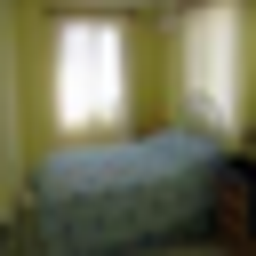

In [ ]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [5, 23, 48]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

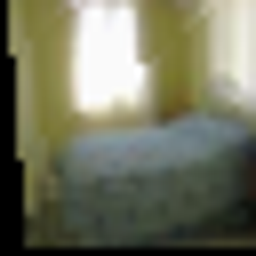

In [ ]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p

     def __len__(self):
         return self.y.size(0)

     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

transform = T.Compose([
     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
     T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2),
                    shear=5),
])

Image.fromarray((transform(torch.Tensor(train_X[50]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

In [ ]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform if part=='train' else None,
                           p=0.5) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2, persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f1660cb8760>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f178d500250>}

In [ ]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        #x = torch.mean(x, axis=-1)
        return torch.flatten(x, start_dim=1) # nhw -> nm

class Cifar100_AE(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_AE, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ELU(),
            nn.Linear(hidden_size//2, hidden_size//8),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size//8, hidden_size//2),
            nn.ELU(),
            nn.Linear(hidden_size//2, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, 32*32*3),
        )

    def forward(self, input):
        normed = self.norm(input)
        encoded = self.encoder(normed)
        out = self.decoder(encoded)
        return out, encoded, normed

HIDDEN_SIZE = 512
model = Cifar100_AE(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model.to(device)

Cifar100_AE(
  (norm): Normalize()
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=512, out_features=3072, bias=True)
  )
)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

  0%|          | 0/2400 [00:00<?, ?it/s]

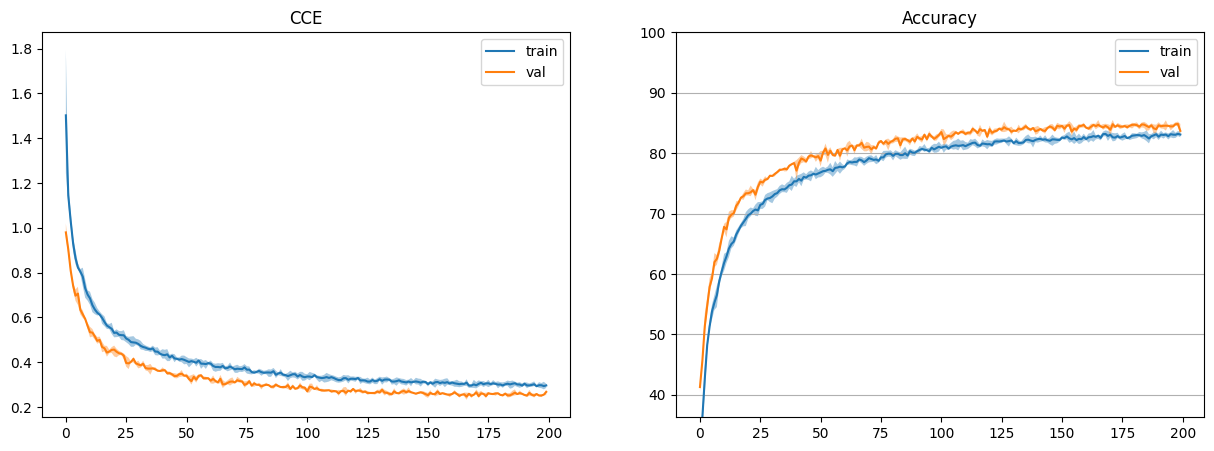

Обучение закончено за 168.422278881073 секунд


In [ ]:
EPOCHS = 200
REDRAW_EVERY = 20
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    #running_loss = 0.0
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, _ = batch
        # на GPU
        inputs, _ = inputs.to(device), _.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs[0], outputs[2])
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = r2_score(outputs[2].detach().cpu().numpy(),
                            outputs[0].detach().cpu().numpy())*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, _ = data
            # на GPU
            inputs, _ = inputs.to(device), _.to(device)

            outputs = model(inputs)
            loss = criterion(outputs[0], outputs[2])
            accuracy = r2_score(outputs[2].detach().cpu().numpy(),
                            outputs[0].detach().cpu().numpy())*100
            tmp.append((loss.item(), accuracy.item()))
    #print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
print('Обучение закончено за %s секунд' % passed)

### Получение результатов обученной модели

In [ ]:
embeddings = []
colors = []
images = []
reconstructs = []
model.eval()
with torch.no_grad():
    for i, batch in enumerate(dataloader['test'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        out, embedding, norm = model(inputs)
        embeddings.append(embedding.detach().cpu().numpy())
        images.append(inputs.detach().cpu().numpy())
        reconstructs.append(out.detach().cpu().numpy())
        colors.append(labels.argmax(-1).detach().cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
images = np.concatenate(images, axis=0)
reconstructs = np.concatenate(reconstructs, axis=0)
reconstructs = (reconstructs-reconstructs.min())/(reconstructs.max()-reconstructs.min())
colors = np.concatenate(colors, axis=0)

### Визуализация восстановленной картинки

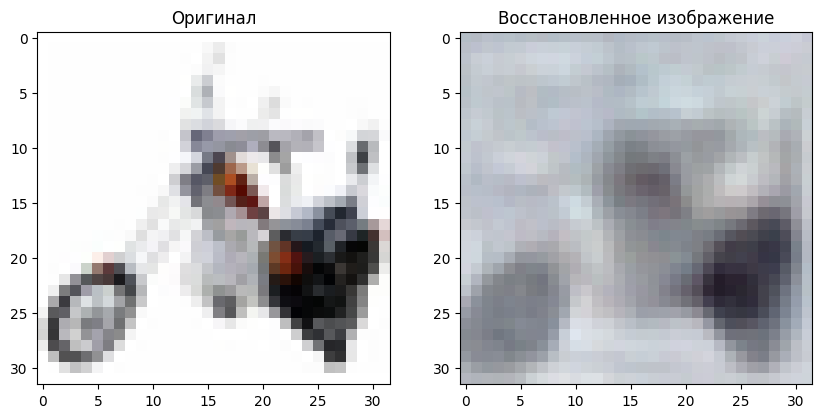

interactive(children=(IntSlider(value=0, description='index', max=300), Output()), _dom_classes=('widget-inter…

<function __main__.draw_comparision(index=0)>

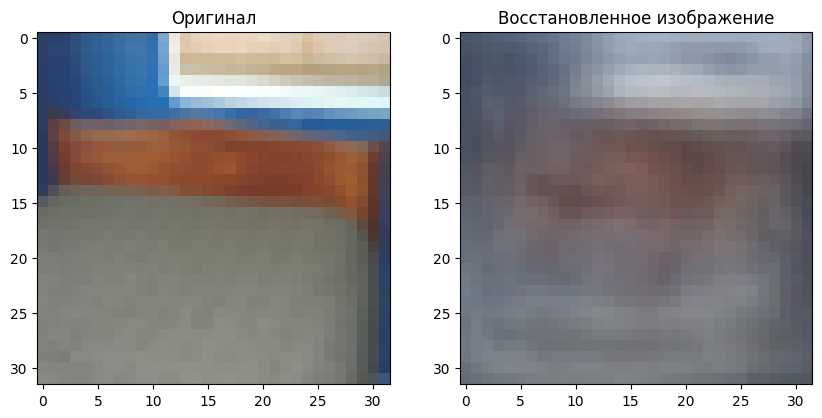

In [ ]:
def draw_comparision(index=0):
   fig, ax = plt.subplots(1, 2, figsize=(10, 5))
   ax[0].imshow(images[index].reshape(32,32,3)/255.)
   ax[1].imshow(reconstructs[index].reshape(32,32,3))
   ax[0].set_title('Оригинал')
   ax[1].set_title('Восстановленное изображение')

interact(draw_comparision, index=(0, len(images)))

### Визуализация эмбеддинга

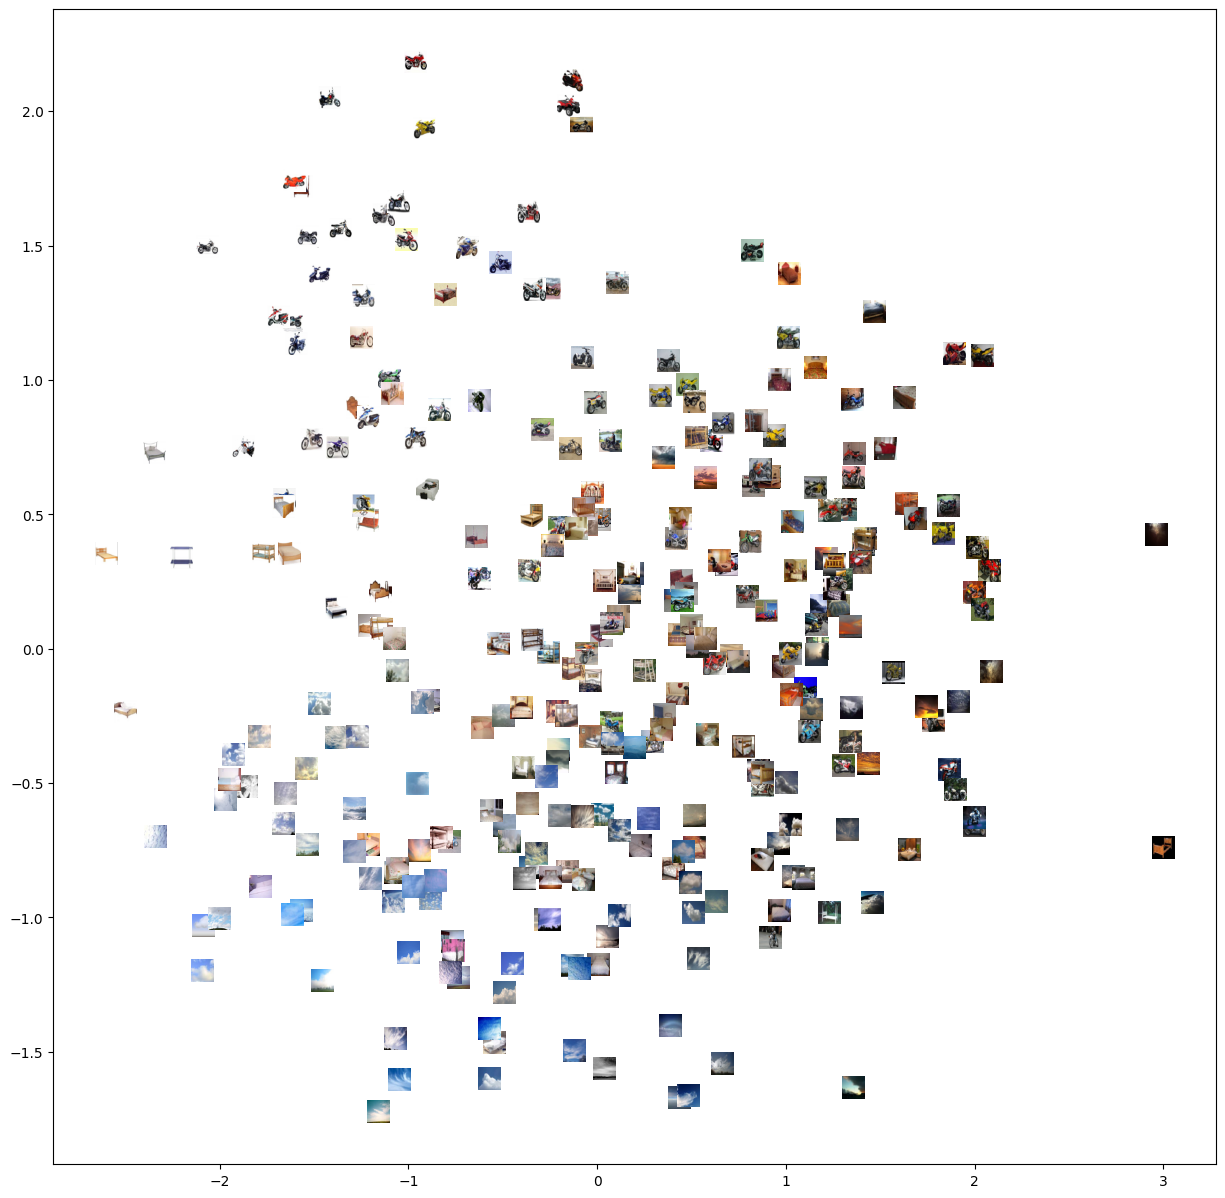

In [ ]:
# Тут мы применяем уменьшение размерности к многомерному
# эмбеддингу, полученному из бутылочного горлышка автоэнкодера.
# Можете попробовать сделать число нейронов равное 2
# и тогда данный этап можно пропустить и написать просто:
# projection = embeddings
projections = PCA(n_components=2).fit_transform(embeddings)

def implot(x, y, image, ax, zoom=1):
    im = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    ax.add_artist(ab)
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
for img, x in zip(images, projections):
    img = img.reshape(32, 32, 3)/255.
    implot(x[0], x[1], img, ax=ax, zoom=0.5)

## Часть 2. Очистка звука

# Новый раздел

In [ ]:

# загрузка мелодии
#!gdown --id 1Qta3KA-vYwMYN14FVdXXRvaRHwS_yJle
# загрузка шумов
#!gdown --folder https://drive.google.com/drive/folders/1j5TXxdWw3Se9S-v-pniXafqeJaB_IUuM?usp=sharing
# конвертация в wav файл с одним каналом и частотой дискретизации 16кГц
!ffmpeg -y -i ae57d42525cfd18.mp3 -ac 1  -ar 16000 audio.wav
!ffmpeg -y -i noise_cut.mp3 -ac 1  -ar 16000 noise.wav

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
# считывание аудио файла
fs, data = wavfile.read('audio.wav')
data = data / (2**16-1)
data[0] = 1
# добавление шума
#noise = np.random.normal(scale=0.25*data.std(), size=data.shape)
_, noise = wavfile.read('noise.wav')
noise = noise / (2**16-1)
noise = np.tile(noise, 1+data.size//noise.size)[:data.size].copy()
noise = (0.1*data.max()/noise.max())*noise
data_noised = data+noise#np.clip(data + noise, -1, 1)

In [ ]:
print('Original')
display(Audio(data[fs*10:fs*25], rate=fs))
print('Noised')
display(Audio(data_noised[fs*10:fs*25], rate=fs))

Original


Noised


In [ ]:
_, _, Zxx = signal.stft(data_noised, fs=fs, nperseg=512)
_, xrec = signal.istft(Zxx, fs)
print('Reconstructed Noised')
display(Audio(xrec[fs*10:fs*25], rate=fs))
_, _, Zxx0 = signal.stft(noise, fs=fs, nperseg=512)
_, xrec = signal.istft(Zxx0, fs)
print('Noise')
display(Audio(xrec[fs*10:fs*25], rate=fs))

Reconstructed Noised


Noise


In [ ]:
# https://github.com/digantamisra98/Mish
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        self.softplus = nn.Softplus()
        self.tanh = nn.Tanh()

    def forward(self, x):
        return x*self.tanh(self.softplus(x))

class DenoisingAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(2, 256, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.Conv1d(512, 1024, kernel_size=3, stride=2, padding=1),
            Mish(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1024, 512, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.ConvTranspose1d(512, 256, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.ConvTranspose1d(256, 2, kernel_size=3, stride=2, padding=1),
        )


    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = DenoisingAE()
net.to(device)
print(Zxx.shape[0])
net(torch.rand(1, 2, Zxx.shape[0], device=device)).detach().cpu().numpy().shape

257


(1, 2, 257)

In [ ]:
criterion = nn.MSELoss()#nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)#, weight_decay=1e-6)

In [ ]:
batch_size = 128

X = np.concatenate([np.real(Zxx).T[:,:,None],
                    np.imag(Zxx).T[:,:,None]], axis=-1)
y = np.concatenate([np.real(Zxx0).T[:,:,None],
                    np.imag(Zxx0).T[:,:,None]], axis=-1)

normalization = X.reshape(-1, 2).std()
X /= normalization
y /= normalization
tensor_x = torch.Tensor(np.transpose(X, [0, 2, 1])) # channels first
tensor_y = torch.Tensor(np.transpose(y, [0, 2, 1])) # channels first

train_dataset = TensorDataset(tensor_x[:tensor_x.shape[0]*9//10],
                              tensor_y[:tensor_x.shape[0]*9//10]) # create your datset
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, shuffle=True) # create your dataloader
test_dataset = TensorDataset(tensor_x[tensor_x.shape[0]*9//10:],
                              tensor_y[tensor_x.shape[0]*9//10:]) # create your datset
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size, shuffle=True) # create your dataloader

In [ ]:
def eval_dataset(dataloader):
    net.eval()
    target = []
    pred = []
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        preds = net(inputs).detach().cpu().numpy()
        target.append(inputs.detach().cpu().numpy().reshape(inputs.shape[0], -1))
        pred.append(preds.reshape(inputs.shape[0], -1))
    net.train()
    target = np.concatenate(target)
    pred = np.concatenate(pred)
    return r2_score(target, pred)

eval_dataset(train_dataloader)

-88.25409047864053

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[1,    10] loss: 0.54938
R2 score on train: 0.38490959370460354
R2 score on val: 0.38114345934802796


0it [00:00, ?it/s]

[2,    10] loss: 0.30392
R2 score on train: 0.7070504310901079
R2 score on val: 0.7153846202458205


0it [00:00, ?it/s]

[3,    10] loss: 0.20785
R2 score on train: 0.8210854743596319
R2 score on val: 0.8429559593933951


0it [00:00, ?it/s]

[4,    10] loss: 0.15205
R2 score on train: 0.8745339095906022
R2 score on val: 0.9023908461347352


0it [00:00, ?it/s]

[5,    10] loss: 0.15324
R2 score on train: 0.887437406500429
R2 score on val: 0.9223719075617893


0it [00:00, ?it/s]

[6,    10] loss: 0.12032
R2 score on train: 0.8874028476489818
R2 score on val: 0.9266360650121076


0it [00:00, ?it/s]

[7,    10] loss: 0.09938
R2 score on train: 0.8997892728338174
R2 score on val: 0.9423516394310669


0it [00:00, ?it/s]

[8,    10] loss: 0.08694
R2 score on train: 0.9076597033583336
R2 score on val: 0.9535026603859554


0it [00:00, ?it/s]

[9,    10] loss: 0.07939
R2 score on train: 0.9064560475862172
R2 score on val: 0.9575383152570258


0it [00:00, ?it/s]

[10,    10] loss: 0.07661
R2 score on train: 0.9043044444598417
R2 score on val: 0.9568553530751668


0it [00:00, ?it/s]

[11,    10] loss: 0.06644
R2 score on train: 0.9032392537482586
R2 score on val: 0.960233698994892


0it [00:00, ?it/s]

[12,    10] loss: 0.07105
R2 score on train: 0.8984636635635207
R2 score on val: 0.9578186879206094


0it [00:00, ?it/s]

[13,    10] loss: 0.06743
R2 score on train: 0.9016323598616697
R2 score on val: 0.9599720342250824


0it [00:00, ?it/s]

[14,    10] loss: 0.05687
R2 score on train: 0.9009346253042896
R2 score on val: 0.961561890390931


0it [00:00, ?it/s]

[15,    10] loss: 0.05282
R2 score on train: 0.9036672774461166
R2 score on val: 0.9642795462686262
Finished Training


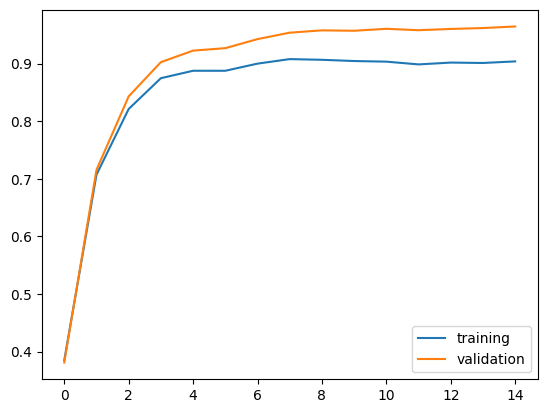

In [ ]:
scores = []
scores_val = []
net.train()
for epoch in tqdm(range(15)):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.5f}')
    scores.append(eval_dataset(train_dataloader))
    scores_val.append(eval_dataset(test_dataloader))
    print('R2 score on train:', scores[-1])
    print('R2 score on val:', scores_val[-1])
print('Finished Training')
plt.plot(scores, label='training')
plt.plot(scores_val, label='validation')
plt.legend()

In [ ]:
net.eval()
pred = []
batch_size = 128
for i in tqdm(range(tensor_x.shape[0]//batch_size+1)):
    preds = net(tensor_x[i*batch_size:(i+1)*batch_size].to(device))
    pred.append(np.transpose(preds.detach().cpu().numpy(),
                             [0, 2, 1])*normalization)
pred = np.concatenate(pred, axis=0)
_, xrec = signal.istft((pred[:,:,0]+pred[:,:,1]*1j).T, fs)
xrec = data_noised - xrec[:data.size]
print(r2_score(data, data_noised))
print(r2_score(data, xrec[:data.size]))
print('Original')
display(Audio(data[fs*50:fs*65], rate=fs))
print('Noised')
display(Audio(data_noised[fs*50:fs*65], rate=fs))
print('Denoised')
display(Audio(xrec[fs*50:fs*65], rate=fs))

  0%|          | 0/11 [00:00<?, ?it/s]

-0.6774218082318775
0.886597381613901
Original


ValueError: ignored

Теперь на базе предоставленного кода используйте свою мелодию/песню и шум по варианту